## 단어의 읨
- 시소러스를 활용한 기법
- 통계 기반 기법
- word2vec

## 시소러스
- WordNet

In [127]:
import numpy as np
import matplotlib.pyplot as plt

In [1]:
text = 'You say goodbye and I say hello.'

In [2]:
text = text.lower()
text = text.replace('.', ' .')
word = text.split()
word

['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']

In [3]:
word2id={}
id2word={}

for w in word:
    if w not in word2id:
        new_id = len(word2id)
        word2id[w]=new_id
        id2word[new_id]=w

In [4]:
word2id

{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}

In [5]:
id2word

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

In [8]:
corpus = np.array([word2id[i] for i in word])
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

In [14]:
def preprocess(text):
    text = text.lower()
    text = text.replace(".", " .")
    word = text.split() 
    
    word2id={}
    id2word={}
    
    for w in word:
        if w not in word2id:
            new_id = len(word2id)
            word2id[w] = new_id
            id2word[new_id] = w 
            
    corpus = [word2id[i] for i in word]
    
    return corpus, word2id, id2word

In [15]:
corpus, word2id, id2word = preprocess(text)   

In [19]:
corpus

[0, 1, 2, 3, 4, 1, 5, 6]

## Statistical based
- 각 단어를 표현할때 window에 해당하는 주변 단어들의 유무로 표현
- 모든 단어 각각의 맥락에 해당하는 단어의 빈도를 세어 표로정리 == > 동시발생 행렬

In [27]:
def create_co_matrix(corpus, vocab_size, window_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size) ,dtype=np.int32)
    
    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size+1):
            left_idx = idx - i
            right_idx = idx + i
            
            if left_idx >= 0 :
                left_word_id =  corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1
                
            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id]+=1
                
    return co_matrix
         

In [36]:
c  =create_co_matrix(corpus, len(word2id))
c

array([[0, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 1, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0]])

## 두 벡터간 유사도 평가(코사인 유사도)

In [35]:
def cos_sim(x,y, eps = 1e-8):
    nx = x / (np.sqrt(np.sum(x**2)+eps))
    ny = y / (np.sqrt(np.sum(y**2)+eps))
              
    return np.dot(nx, ny)

In [37]:
c0 = c[word2id['i']]
c1 = c[word2id['you']]
cos_sim(c0,c1)

0.7071067758832467

In [125]:
def most_similar(query, word2id, id2word, word_matrix, top=3): ## query ==> 유사도를 평가하고자 하는 단어
    try:
        if query not in word2id.keys():
            raise Exception

        query_id = word2id[query]
        query_vec = word_matrix[query_id] ## word_matrix는 단어들을 벡터로 표현한 matrix

        vocab_size = len(id2word)
        similarity = np.zeros(vocab_size)
        for i in range(vocab_size):
            similarity[i] = round(cos_sim(word_matrix[i], query_vec), 4)
        
        print(f"=== {query} ===")
        for idx,i in enumerate((-1 * similarity).argsort()): ## 내림차순 이후 index 반환
            if id2word[i] == query:
                continue
            print(f"{id2word[i]} : {similarity[i]}")

            if idx == top:
                print()
                break
                
    except Exception as e:
        print("no word in the corpus")
    
    
    

In [131]:
most_similar('you', word2id, id2word, c)

=== you ===
we : 0.9117
they : 0.8687
i : 0.8574



## PMI(점별 상호정보량)
- 위에서 구한 동시발생 행렬에선 단지 두 단어 사이의 빈도수를 보며 관련성을 평가지만 이것이 꼭 정확하진 않다.
- 그러므로 동시발생 행렬을 PPMI행렬로 변환하여 좀더 두 단어 사이의 높은 관련성을 포함하는 sparse한 matrix로 변환하여 보자

In [89]:
def ppmi(c, verbose=False, eps=1e-8): ##-inf로 가는것을 방지하기 위해 분모에 eps더해주기
    M = np.zeros_like(c, dtype=np.float32)
    n = np.sum(c)
    s = np.sum(c, axis=0)
    total = c.shape[0] * c.shape[1]
    cnt = 0
    
    for i in range(c.shape[0]):
        for j in range(c.shape[1]):
            pmi = np.log2(c[i,j] * n / (s[j] * s[i]) + eps) ## 두 단어가 같이 등장할 확률 / 각 단어가 등장할 확률의 곱
            M[i,j] = max(0, pmi)
            
            if verbose:
                cnt += 1
                if cnt % (total//100) == 0:
                    print(f"{100*cnt/total}:.4f % 완료")
                    
    return M

In [91]:
w=ppmi(c)
w

array([[0.       , 1.8073549, 0.       , 0.       , 0.       , 0.       ,
        0.       ],
       [1.8073549, 0.       , 0.8073549, 0.       , 0.8073549, 0.8073549,
        0.       ],
       [0.       , 0.8073549, 0.       , 1.8073549, 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 1.8073549, 0.       , 1.8073549, 0.       ,
        0.       ],
       [0.       , 0.8073549, 0.       , 1.8073549, 0.       , 0.       ,
        0.       ],
       [0.       , 0.8073549, 0.       , 0.       , 0.       , 0.       ,
        2.807355 ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 2.807355 ,
        0.       ]], dtype=float32)

##  Dimensionality reduction
- SVD

In [92]:
u,s,v = np.linalg.svd(w)

In [96]:
c.shape, w.shape, u.shape, s.shape, v.shape

((7, 7), (7, 7), (7, 7), (7,), (7, 7))

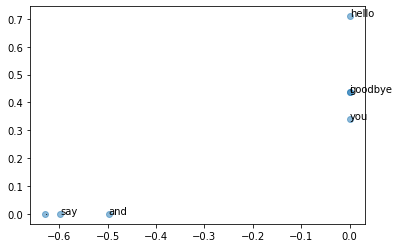

In [102]:
for word, word_id in word2id.items():
    plt.annotate(word, (u[word_id, 0], u[word_id,1]))
    
plt.scatter(u[:,0], u[:,1], alpha=0.5)
plt.show()

In [103]:
import sys
import ptb

In [104]:
corpus, word2id, id2word = ptb.load_data('train')

Done


In [132]:
len(corpus), len(word2id) ## corpus는 총 1만개의 word로 이루어져 있다.

(929589, 10000)

In [109]:
window_size=2
wordvec_size=100
c = create_co_matrix(corpus, len(word2id), window_size)
w = ppmi(c, verbose=True)

<ipython-input-89-3f252f5d50d7>:10: RuntimeWarning: overflow encountered in long_scalars
  pmi = np.log2(c[i,j] * n / (s[j] * s[i]) + eps) ## 두 단어가 같이 등장할 확률 / 각 단어가 등장할 확률의 곱
<ipython-input-89-3f252f5d50d7>:10: RuntimeWarning: invalid value encountered in log2
  pmi = np.log2(c[i,j] * n / (s[j] * s[i]) + eps) ## 두 단어가 같이 등장할 확률 / 각 단어가 등장할 확률의 곱


1.0:.4f % 완료
2.0:.4f % 완료
3.0:.4f % 완료
4.0:.4f % 완료
5.0:.4f % 완료
6.0:.4f % 완료
7.0:.4f % 완료
8.0:.4f % 완료
9.0:.4f % 완료
10.0:.4f % 완료
11.0:.4f % 완료
12.0:.4f % 완료
13.0:.4f % 완료
14.0:.4f % 완료
15.0:.4f % 완료
16.0:.4f % 완료
17.0:.4f % 완료
18.0:.4f % 완료
19.0:.4f % 완료
20.0:.4f % 완료
21.0:.4f % 완료
22.0:.4f % 완료
23.0:.4f % 완료
24.0:.4f % 완료
25.0:.4f % 완료
26.0:.4f % 완료
27.0:.4f % 완료
28.0:.4f % 완료
29.0:.4f % 완료
30.0:.4f % 완료
31.0:.4f % 완료
32.0:.4f % 완료
33.0:.4f % 완료
34.0:.4f % 완료
35.0:.4f % 완료
36.0:.4f % 완료
37.0:.4f % 완료
38.0:.4f % 완료
39.0:.4f % 완료
40.0:.4f % 완료
41.0:.4f % 완료
42.0:.4f % 완료
43.0:.4f % 완료
44.0:.4f % 완료
45.0:.4f % 완료
46.0:.4f % 완료
47.0:.4f % 완료
48.0:.4f % 완료
49.0:.4f % 완료
50.0:.4f % 완료
51.0:.4f % 완료
52.0:.4f % 완료
53.0:.4f % 완료
54.0:.4f % 완료
55.0:.4f % 완료
56.0:.4f % 완료
57.0:.4f % 완료
58.0:.4f % 완료
59.0:.4f % 완료
60.0:.4f % 완료
61.0:.4f % 완료
62.0:.4f % 완료
63.0:.4f % 완료
64.0:.4f % 완료
65.0:.4f % 완료
66.0:.4f % 완료
67.0:.4f % 완료
68.0:.4f % 완료
69.0:.4f % 완료
70.0:.4f % 완료
71.0:.4f % 완료
72.0:.4f % 완료
7

In [126]:
try:
    from sklearn.utils import extmath
    u,s,v = extmath.randomized_svd(w, n_components=wordvec_size, n_iter=5, random_state=None)
except ImportError:
    print("No Module Ranomized_svd")
    
word_vecs = u[:, :wordvec_size]

querys=['you', 'i', 'car', 'toyota']

for q in querys:
    most_similar(q, word2id, id2word, word_vecs, top=5)

=== you ===
we : 0.6524999737739563
i : 0.6467999815940857
do : 0.5837000012397766
anybody : 0.525600016117096
else : 0.4586000144481659

=== i ===
we : 0.7842000126838684
'm : 0.7059000134468079
you : 0.6467999815940857
am : 0.5684999823570251
've : 0.4708000123500824

=== car ===
luxury : 0.6567000150680542
auto : 0.637499988079071
domestic : 0.5723999738693237
vehicle : 0.5026999711990356
truck : 0.49810001254081726

=== toyota ===
motor : 0.7343999743461609
motors : 0.6696000099182129
nissan : 0.6234999895095825
lexus : 0.5983999967575073
hertz : 0.5347999930381775

